In [1]:
from random import *
import pandas as pd


In [3]:
from random import *
import pandas as pd
from collections import Counter
import time
import numpy as np
from collections import Counter

def minmax(l):
    '''
    inputs:
        l: iterable, but basically I envision this being a list
    outputs:
        tuple of (min_value,max_value)
    '''
    lo = min(l)
    hi = max(l)
    return (lo,hi)


def median_string(I, index_list):
    '''
    inputs:
        I: inclusion
        index_list: a list of start/stop coordinates corresponding to strings in I
    return:
        a string containing the most frequently occuring character at each position across I substrings
        
    errors:
    
    '''
    assert all([min(x)>=0 for x in index_list]), 'error provided index_list must not contain negative values'
    mm = minmax([x[1]-x[0] for x in index_list])
    assert mm[0]==mm[1], 'error provided index_list must define equal length substrings of I'
    

    patterns = [I[i][start:stop] for i,(start,stop) in enumerate(index_list)]

    return ''.join([Counter([x[i] for x in patterns]).most_common()[0][0] for i in range(len(patterns[0]))])

def ProfileProb(seq, k, prob_dic):
    minn = 0
    min_pat = []
    for i in range(len(seq) - k + 1):
        pat = seq[i:i+k]
        seq_sum = 0
        for j in range(k):
            seq_sum += prob_dic[pat[j]][j]
        if minn < seq_sum:
            minn = seq_sum
            min_pat = pat
    return min_pat

def Score(dna_list, motiff):
    st, end = motiff[0]
    k = end - st
    score_mat = {"A": [0]*k, "C": [0]*k, "G": [0]*k, "T": [0]*k}
    for indx, (st_nei,end_nei) in enumerate(motiff):
        idx = 0
        for nuc in str(dna_list[indx][st_nei:end_nei]):
            score_mat[nuc][idx] +=1
            idx+=1
    score = 0
    smat = list(zip(*score_mat.values()))
    for i in range(k):
            score = score + sum(smat[i]) - max(smat[i])
    return score

def Profile_creator(dna_list, motiff, initi = 1):
    st, end = motiff[0]
    k = end - st
    profile_matrix = {"A": [initi]*k, "C": [initi]*k, "G": [initi]*k, "T": [initi]*k}
    for indx, (st_nei,end_nei) in enumerate(motiff):
        idx = 0
        for nuc in str(dna_list[indx][st_nei:end_nei]):
            profile_matrix[nuc][idx] +=1
            idx+=1
    for j in range(k):
        col_sum =0
        for i in ["A", "C", "G", "T"]:
            col_sum += profile_matrix[i][j]
        for i in ["A", "C", "G", "T"]:
            profile_matrix[i][j] = profile_matrix[i][j]/col_sum
    return profile_matrix

def RandomMotif(seq, allowed_idx, k, prob_dic):
    allowed_idx_st, allowed_idx_end = allowed_idx
    rand_dic = {}    
    for i in range(allowed_idx_st, allowed_idx_end - k +1):
        pat = seq[i:i+k]
        seq_sum = 1
        for j in range(k):
            seq_sum *= prob_dic[pat[j]][j]
        rand_dic[(i,i+k)] = seq_sum
        
    keey = choices(list(rand_dic.keys()), weights=list(rand_dic.values()))  
    return keey[0]

def GibbsSampler(dna_list, part_index_list, k, t, N):
    motiff = []
    for i, (part_st, part_end) in enumerate(part_index_list):     
        rand = randint(part_st, part_end - k)
        motiff.append((rand, rand + k))      
        
    best_motif = motiff
    for j in range(N):
        i = randint(0,t-1)

        prof = Profile_creator(dna_list, best_motif[:i] + best_motif[i+1:])
        ith_motif_st, ith_motif_end = RandomMotif(dna_list[i], part_index_list[i], k, prof)

        motiff = best_motif[:i] + [(ith_motif_st,ith_motif_end)] + best_motif[i+1:]
        if Score(dna_list, motiff) < Score(dna_list,best_motif):
            best_motif = motiff.copy()
    return best_motif

def hamming_distance(s1,s2):
    assert len(s1)==len(s2), 'strings must be same length'
    return sum([1 for i in range(len(s1)) if s1[i]!=s2[i]])

def Score2(dna_list, motiff):
    if len(motiff) == 0:
        return 0
    st, end = motiff[0]
    k = end - st
    median_str =  median_string(dna_list, motiff)
    score = []
    for i, (mot_st, mot_end) in enumerate(motiff):
            score.append(hamming_distance(median_str, dna_list[i][mot_st:mot_end]))
    return 1 - (max(score)/k)

In [7]:
def Search(I, part_index_list, Match, lmin, outer_runs=1000, inner_runs=100, random_jumps = 300):
    """
    Inclusion -> I
    part_index_list -> Partition index of each string in I
    Match -> Minimum match Threshold
    lmin -> Minimum length of the motif
    """
    
    assert all([min(x)>=0 for x in part_index_list]), 'error provided index_list must not contain negative values'
    
    st0, end0 = part_index_list[0]
    len_part = end0-st0
    best_motifs = []
    min_score = Match
    count = 0
    ctt = 0
    while count < outer_runs:
        lmin_rand = lmin    
        while ctt < inner_runs:
            motifs = GibbsSampler(I, part_index_list, lmin_rand, len(I), random_jumps)
            ss = Score2(I,motifs)
            if ss >= min_score:
                t2 = time.time()
                best_motifs = motifs
                return best_motifs
                min_score = ss
            ctt +=1
        count += 1
        lmin_rand = choices(np.arange(lmin+1, len_part), weights=1/np.arange(lmin+1, len_part)**4)[0]
        
#     print(Score2(I,best_motifs))
    return best_motifs

In [ ]:
%%time
acc =[]
df = pd.DataFrame(columns = ["Test String No.", "Outer Loop", "Inner Loop", "Random Jumps", "Time Taken", "Best Found", "Expected",  "String Len", "Match", "Found?" ])
for outer_runs in [10, 100, 1000]:
    for inner_runs in [10,100,1000]:
        for random_jumps in [100, 500, 1000]:
            correct = 0
            with open("Test one length 10 pattern.txt") as f:
                for teeee in range(100):
                    
                    test = []
                    num_str = 5
                    for tem in range(num_str):
                        test.append(f.readline().strip())
                    expected = f.readline().strip()
                    part_index_list= [(0, len(test[0])) for _ in range(num_str)]
                    t1 = time.time()
                    best_motifs = Search(test, part_index_list, 0.9, 10, outer_runs, inner_runs, random_jumps)
                    t2 = time.time()
                    val = validate(test, [], 0.9, 10, [best_motifs])
                    if val:
                        print("PASSS!!!")
                        correct += 1
                    else:
                        print("NOOOOOOOOOOOOOOOOOOOOOOOOOOO")
                        print(best_motifs)
                        print(expected)
#                         print(Score2(test, best_motifs))
                    
                    print("Time Taken: " + str(t2-t1))
                    new_row = {"Test String No.": teeee, 
                               "Outer Loop": outer_runs,
                               "Inner Loop": inner_runs, 
                               "Random Jumps": random_jumps, 
                               "Time Taken": t2-t1, 
                               "Best Found": best_motifs, 
                               "Expected": expected,
                               "String Len": len(test[0]),
                               "Match": Score2(test, best_motifs),
                               "Found?": val}
                    df = df.append(new_row, ignore_index=True)
                print("Accuracy: " + str(correct/100))
                acc.append(correct/100)

In [ ]:
df.to_csv("Ress2.csv")

In [34]:
# df = pd.read_csv("Res2.csv")

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
df

Unnamed: 0  Test String No.  Outer Loop  Inner Loop  Random Jumps  \
0              0                0          10          10           100   
1              1                1          10          10           100   
2              2                2          10          10           100   
3              3                3          10          10           100   
4              4                4          10          10           100   
...          ...              ...         ...         ...           ...   
2695        2695               95        1000        1000          1000   
2696        2696               96        1000        1000          1000   
2697        2697               97        1000        1000          1000   
2698        2698               98        1000        1000          1000   
2699        2699               99        1000        1000          1000   

      Time Taken                                         Best Found  \
0       0.071535                                                 []   
1       0.059169                                                 []   
2       0.051220  [(40, 50), (18, 28), (31, 41), (24, 34), (32, ...   
3       0.005718  [(37, 47), (21, 31), (1, 11), (30, 40), (15, 25)]   
4       0.034352  [(0, 10), (24, 34), (35, 45), (11, 21), (34, 44)]   
...          ...                                                ...   
2695    1.560486    [(30, 40), (6, 16), (0, 10), (6, 16), (37, 47)]   
2696    0.286189   [(23, 33), (14, 24), (9, 19), (19, 29), (2, 12)]   
2697    0.058188   [(2, 12), (30, 40), (3, 13), (23, 33), (30, 40)]   
2698    0.343414   [(0, 10), (40, 50), (8, 18), (29, 39), (20, 30)]   
2699    0.922026  [(29, 39), (36, 46), (11, 21), (24, 34), (23, ...   

                                          Expected  String Len  Match  Found?  
0       (0, 10) (15, 25) (10, 20) (0, 10) (19, 29)          50    0.0   False  
1     (11, 21) (21, 31) (31, 41) (31, 41) (37, 47)          50    0.0   False  
2     (40, 50) (18, 28) (31, 41) (24, 34) (32, 42)          50    0.9    True  
3      (37, 47) (21, 31) (1, 11) (30, 40) (15, 25)          50    0.9    True  
4      (0, 10) (24, 34) (35, 45) (11, 21) (34, 44)          50    0.9    True  
...                                            ...         ...    ...     ...  
2695    (30, 40) (6, 16) (0, 10) (23, 33) (37, 47)          50    0.9    True  
2696    (23, 33) (14, 24) (9, 19) (19, 29) (2, 12)          50    0.9    True  
2697    (2, 12) (30, 40) (3, 13) (23, 33) (30, 40)          50    0.9    True  
2698    (0, 10) (40, 50) (8, 18) (29, 39) (20, 30)          50    0.9    True  
2699  (29, 39) (36, 46) (11, 21) (24, 34) (23, 33)          50    0.9    True  

[2700 rows x 11 columns]

In [10]:
fig, ax = plt.subplots(figsize=(6,4))
ax1 = ax.twinx()
df.groupby(["Outer Loop", "Inner Loop", "Random Jumps"]).sum()["Found?"].unstack(level=0).plot(kind="bar", ax=ax)
df.groupby(["Outer Loop", "Inner Loop", "Random Jumps"]).mean()["Time Taken"].unstack(level=0).plot(kind="line",ax=ax1)

NameError: name 'plt' is not defined

In [73]:
sns.heatmap

/var/folders/_8/tqnhz5dn2q77dh1l3q_btskc0000gn/T/ipykernel_56315/338487436.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(["Outer Loop", "Inner Loop", "Random Jumps"]).sum()[[ "Time Taken"]].unstack(level=0).plot(kind="bar")


<AxesSubplot: xlabel='Inner Loop,Random Jumps'>

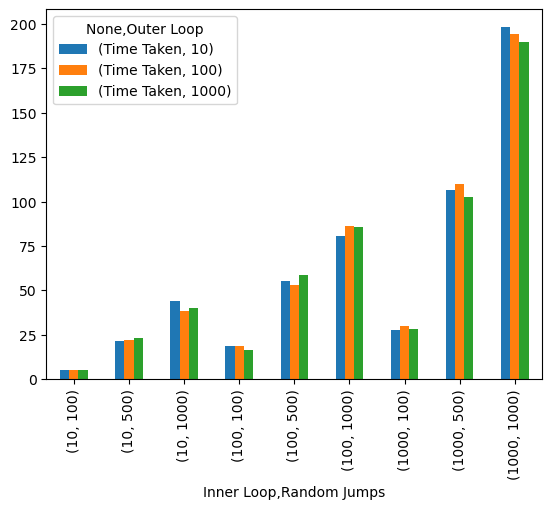

In [56]:
df.groupby(["Outer Loop", "Inner Loop", "Random Jumps"]).sum()[[ "Time Taken"]].unstack(level=0).plot(kind="bar")

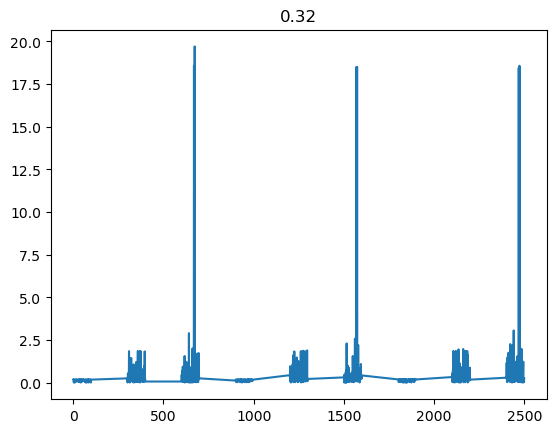

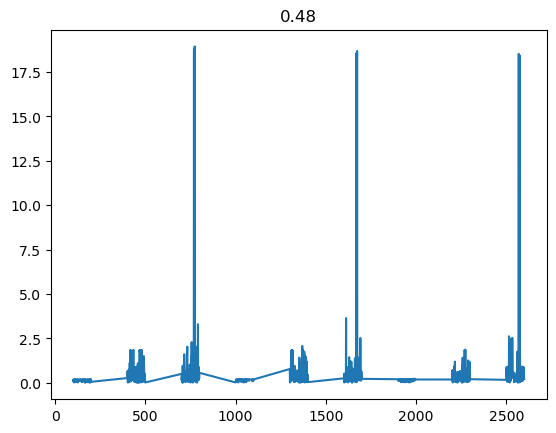

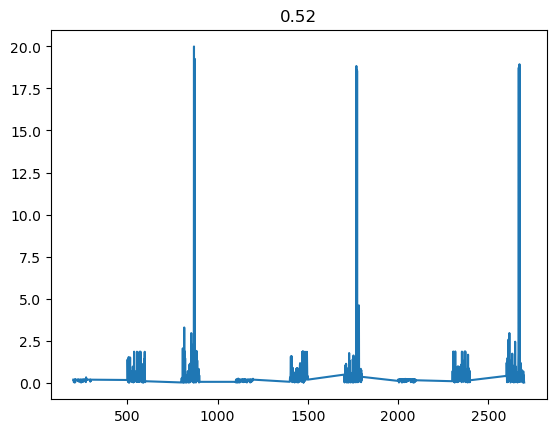

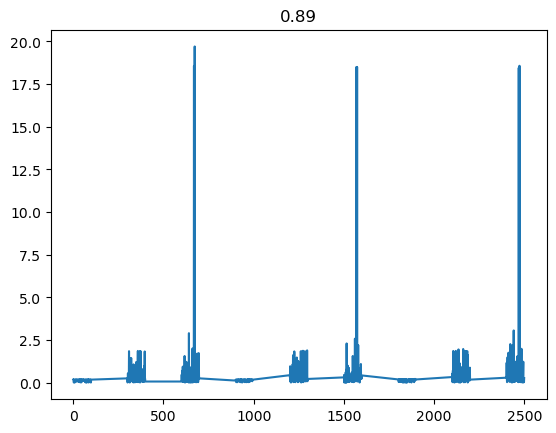

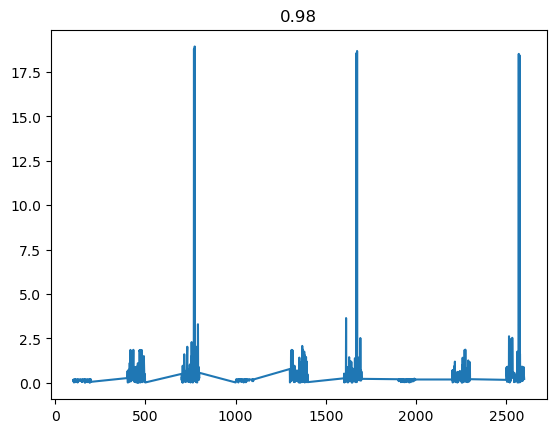

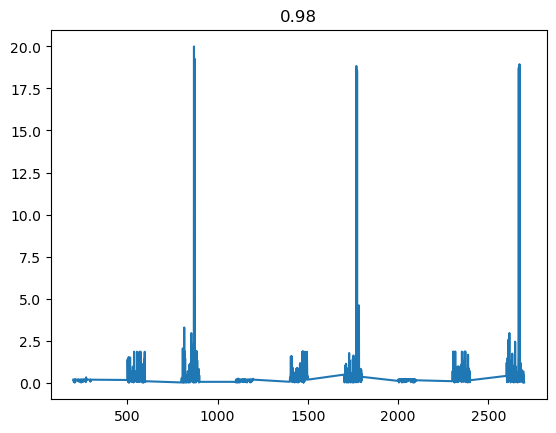

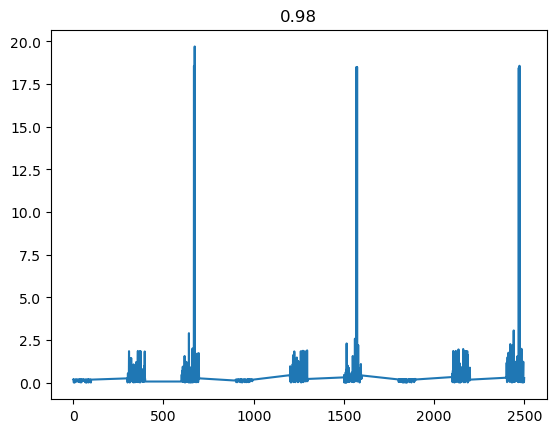

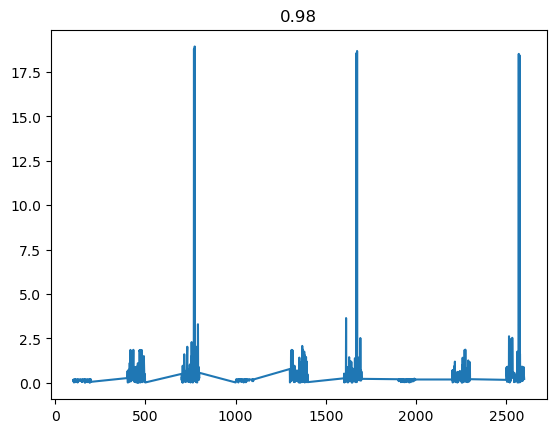

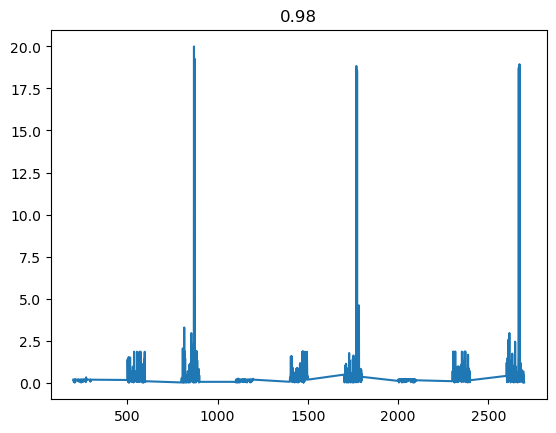

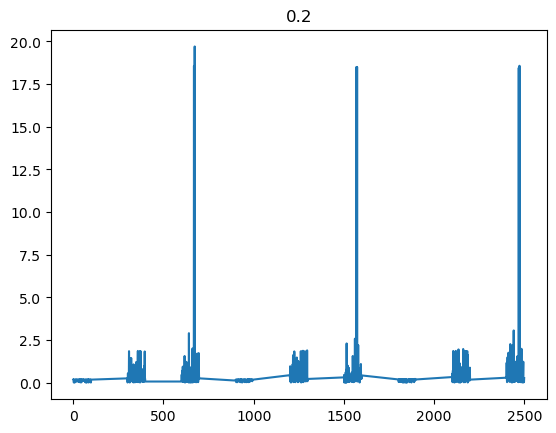

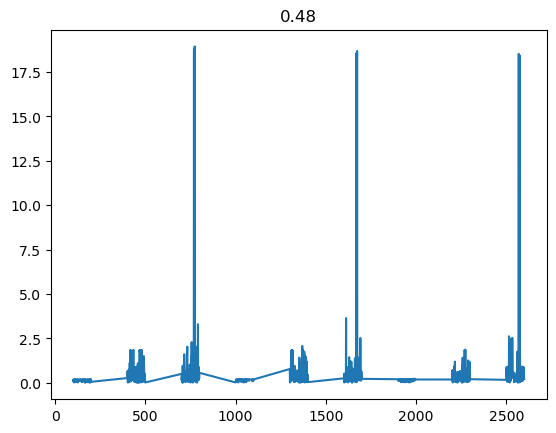

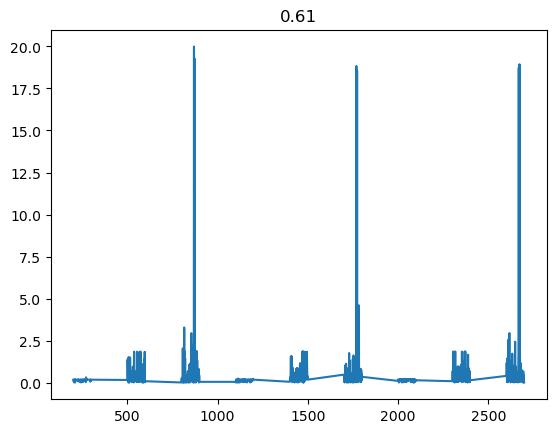

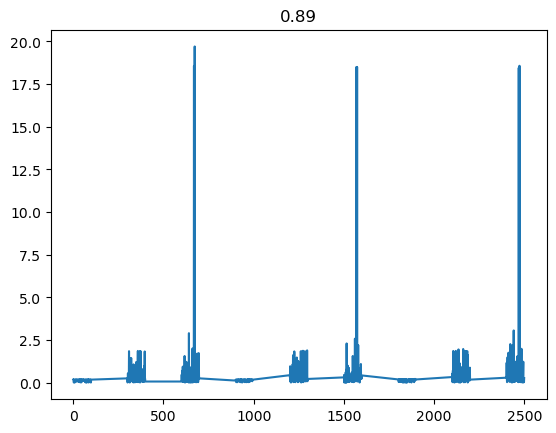

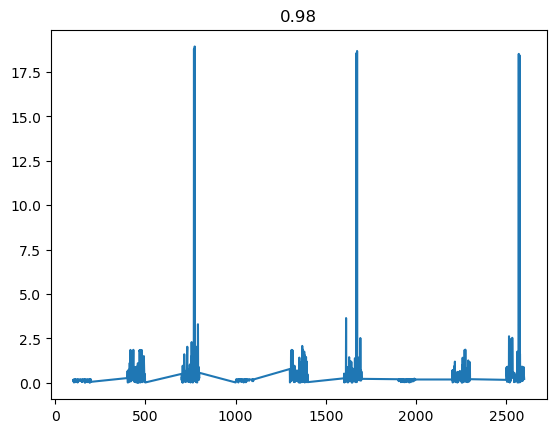

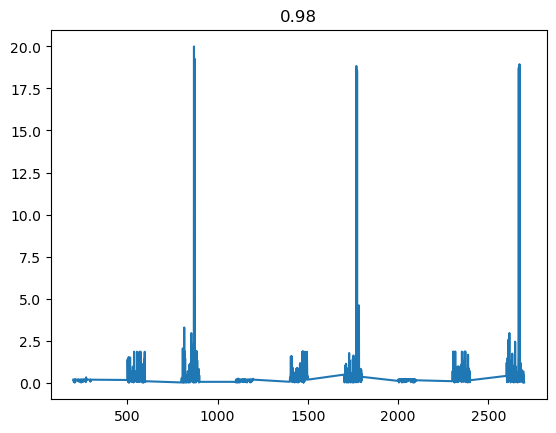

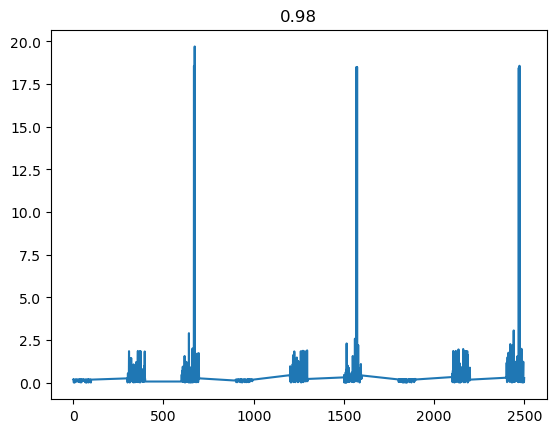

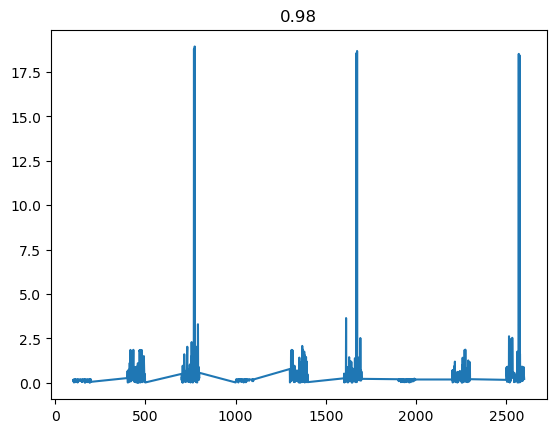

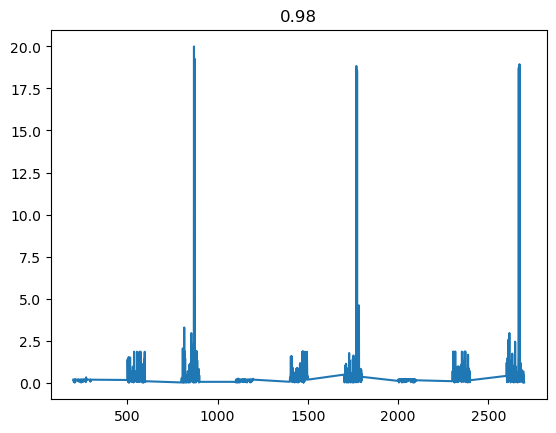

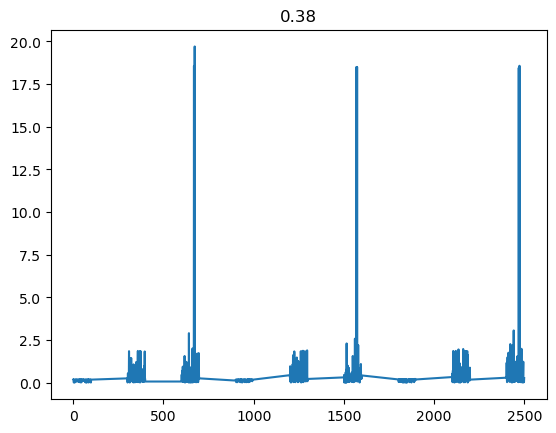

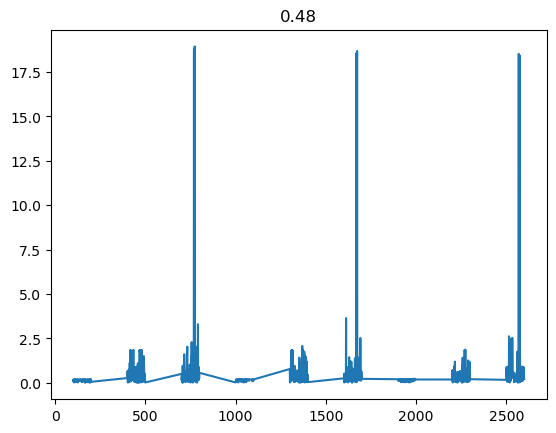

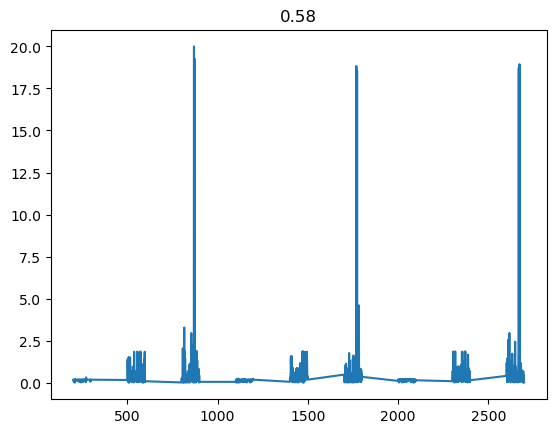

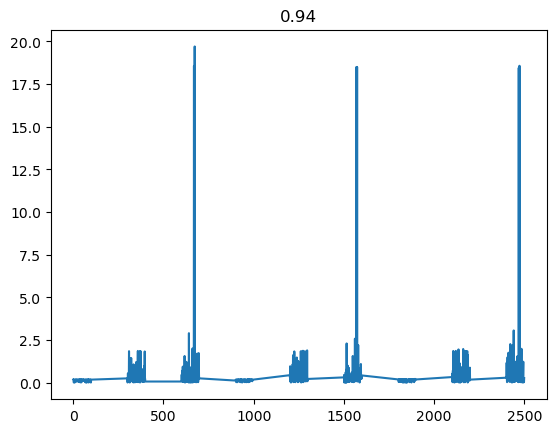

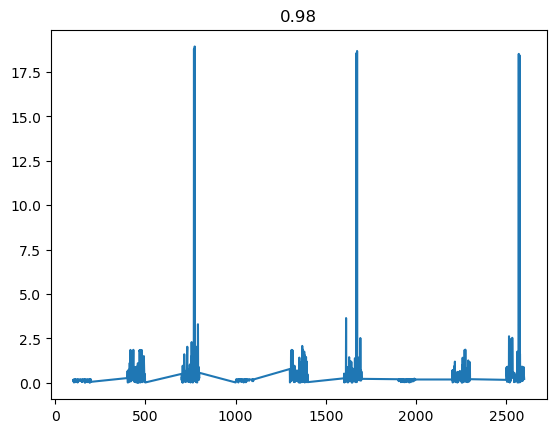

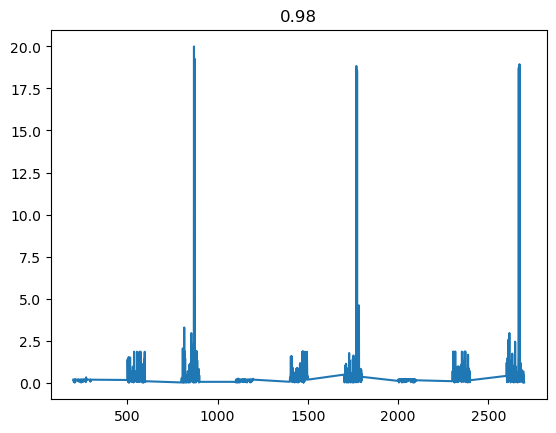

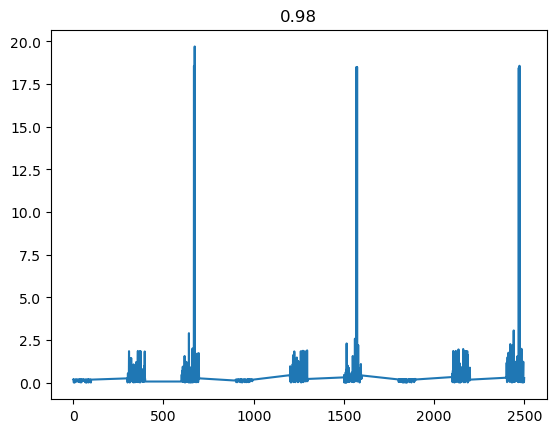

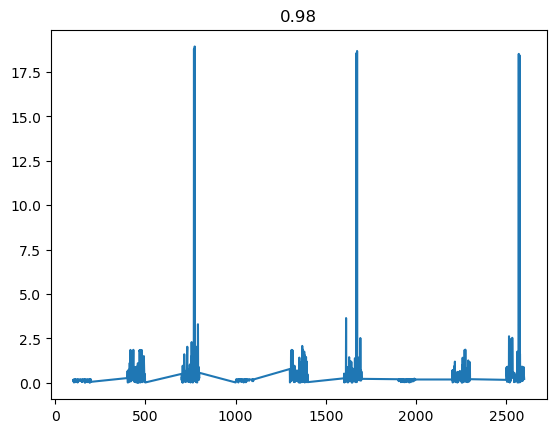

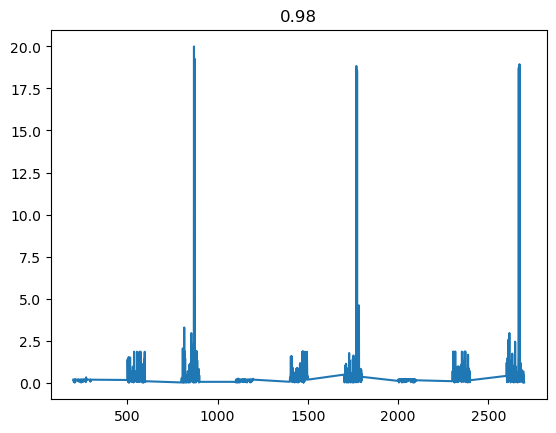

In [27]:
i = 0
for outer_runs in enumerate([10, 100, 1000]):
    for inner_runs in [10,100,1000]:
        for random_jumps in [100, 500, 1000]:
            plt.plot(df.groupby("Random Jumps")[df["Random Jumps"] == random_jumps]["Time Taken"])
            plt.title(acc[i])
            plt.show()
            i+=1

In [ ]:
df

In [23]:
len(acc)

27

In [5]:
def validate(I,E,match,lmin,answer):
    ret = True
    if len(answer[0]) == 0:
        return False
    
    #match criteria
    for i in range(len(answer)):
        cur = answer[i]
        temp = [I[i][start:stop] for i,(start,stop) in enumerate(cur)]
        med = median_string(I,cur)
        cur_match = 1-max([hamming_distance(x,med)/len(med) for x in temp])>=match
        if cur_match<match:
            print("error, pattern {i} does not meet match criteria".format(i=i))
            ret = False

    #no overlap
    for i in range(len(answer)-1):
        prev = answer[i]
        cur = answer[i+1]
        for j in range(len(prev)):
            gap = cur[j][0]-prev[j][1]
            if gap<1:
                print("error, patterns {i} and {k} do not meet gap criteria in string I[{j}]".format(i=i,j=j,k=i+1))
                ret = False

    #excluded criteria
#     excluded_dic = get_excluded_dic(E,lmin)
#     for i,cur in answer:
#         med = median_string(I,cur)
#         if is_excluded(cur,lmin,E,excluded_dic):
#             print("error, pattern {i} does not meet exclusion criteria")
#             ret = False
    return ret


In [4]:
import random
from collections import Counter
random.seed(666, 2)
import bisect
import networkx as nx
from itertools import product
from functools import reduce

def validate(I,E,match,lmin,answer):
    ret = True
    
    #match criteria
    for i in range(len(answer)):
        cur = answer[i]
        temp = [I[i][start:stop] for i,(start,stop) in enumerate(cur)]
        med = median_string(I,cur)
        cur_match = 1-max([hamming_distance(x,med)/len(med) for x in temp])>=match
        if cur_match<match:
            print("error, pattern {i} does not meet match criteria".format(i=i))
            ret = False

    #no overlap
    for i in range(len(answer)-1):
        prev = answer[i]
        cur = answer[i+1]
        for j in range(len(prev)):
            gap = cur[j][0]-prev[j][1]
            if gap<1:
                print("error, patterns {i} and {k} do not meet gap criteria in string I[{j}]".format(i=i,j=j,k=i+1))
                ret = False

    #excluded criteria
    excluded_dic = get_excluded_dic(E,lmin)
    for i,cur in answer:
        med = median_string(I,cur)
        if is_excluded(cur,lmin,E,excluded_dic):
            print("error, pattern {i} does not meet exclusion criteria")
            ret = False
    return ret

def get_pattern_list(sstarts,pattern_dic):
    
    def get_groups(pi,sstarts):
        insertion_points = [bisect.bisect_left(pi,x) for x in sstarts] + [len(pi)]

        return [pi[insertion_points[i]:insertion_points[i+1]] for i in range(len(sstarts))]

    def get_nodes(pi,sstarts,pattern):
        temp =  product(*get_groups(pi,sstarts))
        return [(*x,pattern) for x in temp]

    def connect_nodes(graph):
        for i in range(len(graph.nodes)):
            for j in range(i+1,len(graph.nodes)):
                n1 = list(graph.nodes)[i]
                n2 = list(graph.nodes)[j]

                if all([n1[i]+len(n1[-1])+1<n2[i] for i in range(len(n1)-1)]):
                    graph.add_edge(n1,n2)
                elif all([n1[i]>n2[i]+len(n2[-1])+1 for i in range(len(n1)-1)]):
                    graph.add_edge(n1,n2)

    def add_nodes(graph, pi,sstarts,pattern):
        graph.add_nodes_from(get_nodes(pi,sstarts,pattern) )
        
    graph = nx.DiGraph()


    for p in pattern_dic:
        add_nodes(graph, pattern_dic[p], sstarts, p)


    connect_nodes(graph)

    return nx.dag_longest_path(graph)

def is_found(pi,sstarts):
 
    if len(pi)<len(sstarts):
        return False

    insert_points = [bisect.bisect_left(pi,x) for x in sstarts]
    print(insert_points)
    if len(set(insert_points))<len(insert_points):
        return False
    
    if max(insert_points)>=len(pi):
        return False
    
    return True

def hamming_distance(s1,s2):
    assert len(s1)==len(s2), 'strings must be same length'
    return sum([1 for i in range(len(s1)) if s1[i]!=s2[i]])

# def validateBWT(I,E,match,lmin,answer, ans_patterns):
#     ret = True
    
#     #match criteria
#     for i in range(len(answer)):
#         cur = answer[i]
#         temp = [I[i][start:stop] for i,(start,stop) in enumerate(cur)]
#         med = ans_patterns[i]
#         # print(1-max([hamming_distance(x,med)/len(med) for x in temp]))
#         cur_match = 1-max([hamming_distance(x,med)/len(med) for x in temp])>=match
#         if cur_match<match:
#             print("error, pattern {i} does not meet match criteria".format(i=i))
#             ret = False

#     #no overlap
#     for i in range(len(answer)-1):
#         prev = answer[i]
#         cur = answer[i+1]
#         for j in range(len(prev)):
#             gap = cur[j][0]-prev[j][1]
#             if gap<1:
#                 print("error, patterns {i} and {k} do not meet gap criteria in string I[{j}]".format(i=i,j=j,k=i+1))
#                 print(answer[i])
#                 print(answer[i+])
#                 ret = False

#     #excluded criteria
#     excluded_dic = get_excluded_dic(E,lmin)
#     for pat in ans_patterns:
#         if is_excluded(pat,lmin,E,excluded_dic):
#             print("error, pattern {i} does not meet exclusion criteria")
#             ret = False
#     return ret


def minmax(l):
    '''
    inputs:
        l: iterable, but basically I envision this being a list
    outputs:
        tuple of (min_value,max_value)
    '''
    lo = min(l)
    hi = max(l)
    return (lo,hi)

def get_excluded_dic(E, lmin):
    '''
    inputs:
        E: exclusion
        lmin: shortes acceptable pattern
    returns:
        dic; keys are lmin-length strings and values are lists of tuples (string_index, start_index)
            string_index indicates which E string; start_index indicates where in E[string_index] the key occurs
    '''
    
    excluded_lmin_mers = {}
    for i,e in enumerate(E):
        for j in range(len(e)-lmin+1):
            cur = E[i][j:j+lmin]
            try:
                excluded_lmin_mers[cur].append((i,j))
            except:
                excluded_lmin_mers[cur] = [(i,j)]
                
    return excluded_lmin_mers


def median_string(I, index_list):
    '''
    inputs:
        I: inclusion
        index_list: a list of start/stop coordinates corresponding to strings in I
    return:
        a string containing the most frequently occuring character at each position across I substrings
        
    errors:
    
    '''
    assert all([min(x)>=0 for x in index_list]), 'error provided index_list must not contain negative values'
    mm = minmax([x[1]-x[0] for x in index_list])
    assert mm[0]==mm[1], 'error provided index_list must define equal length substrings of I'
    

    patterns = [I[i][start:stop] for i,(start,stop) in enumerate(index_list)]

    return ''.join([Counter([x[i] for x in patterns]).most_common()[0][0] for i in range(len(patterns[0]))])


def is_excluded(p, lmin, E,ex_dic=None):
    '''
    inputs:
        p: a string
        lmin: minimum acceptable pattern length
        E: an exclusion set
        ex_dic: result of get_excluded_dic(E, lmin); if default (None) will call get_excluded_dic with given E and lmin
    outputs:
        True/False whether string p can be found exactly in any string of E
        
    '''
    if ex_dic is None:
        ex_dic = get_excluded_dic(E,lmin)
    
    try:
        assert len(p)>= lmin
        pref = p[:lmin]
        locs = ex_dic[pref]
        
        for i,start in locs:
            if p == E[i][start:start+len(p)]:
                return True
            
        return False
    except:
        return False
    
def chop(I, index_list, lmin, factor = 2, exp = 4):
    '''
    inputs:
        I: inclusion multiset of strings
        index_list: regions within inclusion strings considered valid
        lmin: minimum acceptable pattern length
        factor: chop will return index_list covering lmin*factor length substrings
        exp: higher positive values increase liklihood of randomly selected subregions appearing to the left
        
    return:
        res: list of indexes covering equal length regions of length lmin*factor
        
    errors:
        raises assertion error if index_list contains negative numbers
        raises assertion error if a substring of I defined by index_list is shorter than int(lmin*factor)
        
    '''
    assert all([min(x)>=0 for x in index_list]), 'error provided index_list must not contain negative values'
    assert all([(x[1]-x[0])>=int(lmin*factor) for x in index_list]), 'error: regions of length {x} not possible in all strings based on given index_list'.format(x=int(lmin*factor))

    
    lo = [x[1]-x[0] for x in index_list]
    
    res = []

    for i,x in enumerate(I):
        siz_range = range(index_list[i][0], index_list[i][1] - int(lmin*factor)+1)
        a = random.choices(siz_range, map(lambda y: (len(x)-y)**exp, siz_range))[0]
        res.append((a,a+int(factor*lmin)))
    return res
